## Data Preprocessing
데이터 전처리란 데이터 분석(모델링) 방향에 맞도록 데이터를 정제하는 작업을 의미합니다.<br>
실제 데이터 분석에서 70% 이상을 차지하기도 합니다.<br>
앞서 EDA를 통해 살펴본 내용을 바탕으로 간단한 데이터 전처리를 진행한 뒤 모델링까지 해보도록 하겠습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('./data/titanic.csv')
test_df = pd.read_csv('./data/test.csv')

### Null 값 제거

In [2]:
# Null 값 확인
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
# Age -> 중간 값을 채우기
train_df.groupby(['Sex', 'Pclass'])['Age'].median()

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [5]:
# df['Age']
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
test_df['Age'] = test_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [6]:
print(train_df['Age'].isnull().sum())
print(test_df['Age'].isnull().sum())

0
0


In [7]:
# Cabin -> 데이터에 비해 null값이 너무 많이 존재함 -> 학습에 사용하지 않음
train_df['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [8]:
# Embarked -> S의 비중이 높음 -> S로 Null 값 채우기
train_df['Embarked'] = train_df['Embarked'].fillna('S')
test_df['Embarked'] = test_df['Embarked'].fillna('S')

print(train_df['Embarked'].isnull().sum())
print(test_df['Embarked'].isnull().sum())

0
0


In [9]:
# Fare -> Pclass가 가장 많은 영향을 미치기에 Pclass를 기준으로 null값 채우기
test_df['Fare'] = test_df.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

In [10]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


### One-Hot-Encoding
범주형 변수를 숫자로 바꿔서 모델링에 사용하는 방법

In [11]:
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [12]:
# Sex와 Embarked 사용
cate_col = []
for i in [4, 11]:
    cate_col.append(train_df.columns[i])
print(cate_col)

# one-hot-encoding 사용
train_cate_df = pd.get_dummies(train_df.loc[:, (cate_col)], drop_first = True)
test_cate_df = pd.get_dummies(test_df.loc[:, (cate_col)], drop_first = True)
test_cate_df

['Sex', 'Embarked']


Sex_male  Embarked_Q  Embarked_S
0           1           1           0
1           0           0           1
2           1           1           0
3           1           0           1
4           0           0           1
..        ...         ...         ...
413         1           0           1
414         0           0           0
415         1           0           1
416         1           0           1
417         1           0           0

[418 rows x 3 columns]

In [13]:
# 데이터 프레임 결합
train_df = pd.concat(objs = [train_df, train_cate_df], axis=1).reset_index(drop=True)
test_df = pd.concat(objs = [test_df, test_cate_df], axis=1).reset_index(drop=True)

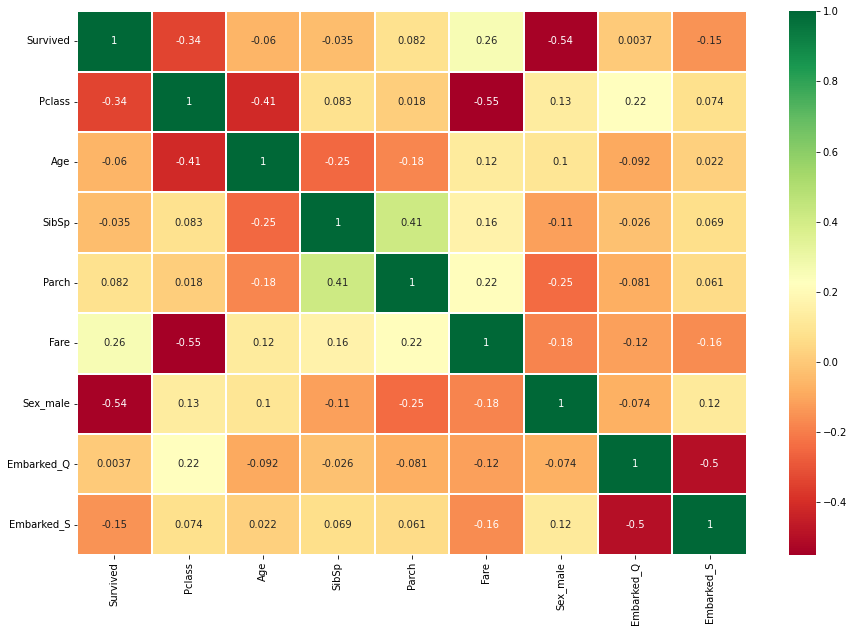

In [14]:
sns.heatmap(train_df.drop(['PassengerId'], axis=1).corr(), annot = True, cmap='RdYlGn', linewidth=0.2)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

### Modeling
실제 데이터를 머신러닝을 통해 학습시켜 모델을 만드는 과정입니다.<br>
이번 실습에서는 간단하게 의사결정나무로 모델링을 하는 것을 실습하겠습니다.<br>

In [15]:
from sklearn.tree import DecisionTreeClassifier
X_data = train_df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived'], axis=1)
y_data = train_df[['Survived']]
test_df = test_df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
tree = DecisionTreeClassifier(criterion = 'gini',
                             max_depth = 4,
                             random_state=1)
tree.fit(X_data, y_data) # 학습
tree

DecisionTreeClassifier(max_depth=4, random_state=1)

In [17]:
test_df

Pclass   Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S
0         3  34.5      0      0    7.8292         1           1           0
1         3  47.0      1      0    7.0000         0           0           1
2         2  62.0      0      0    9.6875         1           1           0
3         3  27.0      0      0    8.6625         1           0           1
4         3  22.0      1      1   12.2875         0           0           1
..      ...   ...    ...    ...       ...       ...         ...         ...
413       3  24.0      0      0    8.0500         1           0           1
414       1  39.0      0      0  108.9000         0           0           0
415       3  38.5      0      0    7.2500         1           0           1
416       3  24.0      0      0    8.0500         1           0           1
417       3  24.0      1      1   22.3583         1           0           0

[418 rows x 8 columns]

In [18]:
test_df['Survived'] = tree.predict(test_df)
test_df

Pclass   Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S  \
0         3  34.5      0      0    7.8292         1           1           0   
1         3  47.0      1      0    7.0000         0           0           1   
2         2  62.0      0      0    9.6875         1           1           0   
3         3  27.0      0      0    8.6625         1           0           1   
4         3  22.0      1      1   12.2875         0           0           1   
..      ...   ...    ...    ...       ...       ...         ...         ...   
413       3  24.0      0      0    8.0500         1           0           1   
414       1  39.0      0      0  108.9000         0           0           0   
415       3  38.5      0      0    7.2500         1           0           1   
416       3  24.0      0      0    8.0500         1           0           1   
417       3  24.0      1      1   22.3583         1           0           0   

     Survived  
0           0  
1           0  
2           0  
3           0  
4           1  
..        ...  
413         0  
414         1  
415         0  
416         0  
417         0  

[418 rows x 9 columns]